In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
from torch.nn.functional import relu
from scipy.io import loadmat
import os
from os import listdir
import pandas as pd
from skimage import io
from PIL import Image
from sklearn.metrics import confusion_matrix
import seaborn as sn

from utils import *

In [2]:
train_loader, val_loader = create_dataloaders(batch_size=128, version='v5')

In [3]:
len(train_loader), len(val_loader)

(87, 35)

date:180410, rec:005
date:180409, rec:003


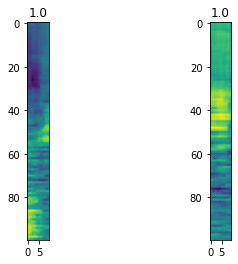

In [5]:
for batch_idx, (data, labels, date, rec) in enumerate(train_loader):
    print('date:{}, rec:{}'.format(date[0], rec[0]))
    data_sub = data[0][0]
    # plt.axis('off')
    plt.subplot(1,2,1)
    plt.imshow(data_sub)
    plt.title(labels[0][0].numpy())
    # plt.clim(-1, 1)
    # plt.show()
    break
for batch_idx, (data, labels, date, rec) in enumerate(train_loader):
    print('date:{}, rec:{}'.format(date[0], rec[0]))
    data_sub = data[0][0]
    # plt.axis('off')
    plt.subplot(1,2,2)
    plt.imshow(data_sub)
    plt.title(labels[0][0].numpy())
    # plt.clim(-1, 1)
    plt.show()
    break

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

tol = 0.01
learning_rate = 0.001
num_epochs = 80
l2 = 0
alpha = 0
CH = 'all'

model = LogReg().to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

cuda


In [7]:
epochs = []
training_losses = []
training_acc = []
val_losses = []
validation_acc = []

train_predictions = []
validation_predictions = []
train_preds_probs = []
validation_preds_probs = []
train_labels = []
validation_labels = []

for epoch in range(num_epochs):
    avg_train_loss, train_acc, train_preds, train_preds_probs, train_labs = train(model, criterion, optimizer, train_loader, epoch, alpha=alpha)
    print('Train loss for epoch {}: {}'.format(epoch, avg_train_loss))
    val_loss, val_acc, val_preds, val_preds_probs, val_labels = test(model, criterion, optimizer, val_loader)
    print('Val loss for epoch {}: {}'.format(epoch, val_loss))
    if val_losses:
        if val_loss < min(val_losses):
            path = '/mnt/pesaranlab/People/Capstone_students/Yue/model_v5'
            torch.save(model.state_dict(), '{}/lr_CH{}_reg{}_alpha{}_epoch{}.pt'.format(path, CH, l2, alpha, epoch))
    epochs.append(epoch)
    training_losses.append(avg_train_loss)
    training_acc.append(train_acc)
    val_losses.append(val_loss)
    validation_acc.append(val_acc)
    
    train_predictions.append(train_preds)
    train_labels.append(train_labs)
    train_preds_probs.append(train_preds_probs)
    validation_predictions.append(val_preds)
    validation_labels.append(val_labels)
    validation_preds_probs.append(val_preds_probs)
    
    if avg_train_loss < tol:
        break

Train loss for epoch 0: 1.5610755681991577
Val loss for epoch 0: 0.9537086486816406
Train loss for epoch 1: 0.6726600527763367
Val loss for epoch 1: 1.000208854675293
Train loss for epoch 2: 0.5088858008384705
Val loss for epoch 2: 0.7557248473167419
Train loss for epoch 3: 0.4823232889175415
Val loss for epoch 3: 1.3530455827713013
Train loss for epoch 4: 0.4800037443637848
Val loss for epoch 4: 1.107128381729126
Train loss for epoch 5: 0.44538503885269165
Val loss for epoch 5: 0.8152080178260803
Train loss for epoch 6: 0.37026354670524597
Val loss for epoch 6: 1.0559296607971191
Train loss for epoch 7: 0.5979019999504089
Val loss for epoch 7: 1.106212854385376
Train loss for epoch 8: 0.450958251953125
Val loss for epoch 8: 0.8590102195739746
Train loss for epoch 9: 0.4085956811904907
Val loss for epoch 9: 0.9030112624168396
Train loss for epoch 10: 0.3270380198955536
Val loss for epoch 10: 0.8653416037559509
Train loss for epoch 11: 0.4341958463191986
Val loss for epoch 11: 1.1467168

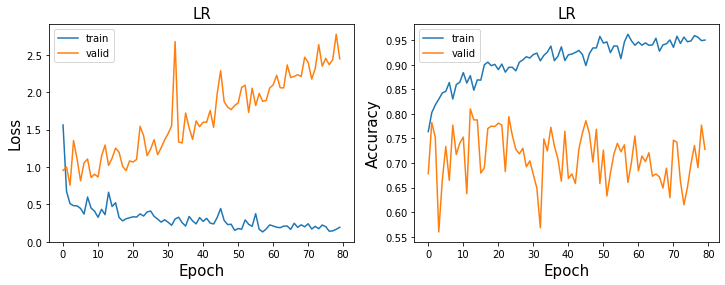

In [8]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.title("LR", fontsize = 15)
plt.plot(training_losses,linewidth = 1.5,label = 'train')
plt.plot(val_losses,linewidth = 1.5,label = 'valid')
plt.xlabel("Epoch",fontsize = 15)
plt.ylabel("Loss", fontsize = 15)
plt.legend()
plt.subplot(1,2,2)
plt.title("LR", fontsize = 15)
plt.plot(training_acc,linewidth = 1.5,label = 'train')
plt.plot(validation_acc,linewidth = 1.5,label = 'valid')
plt.xlabel("Epoch",fontsize = 15)
plt.ylabel("Accuracy", fontsize = 15)
plt.legend()
plt.show()

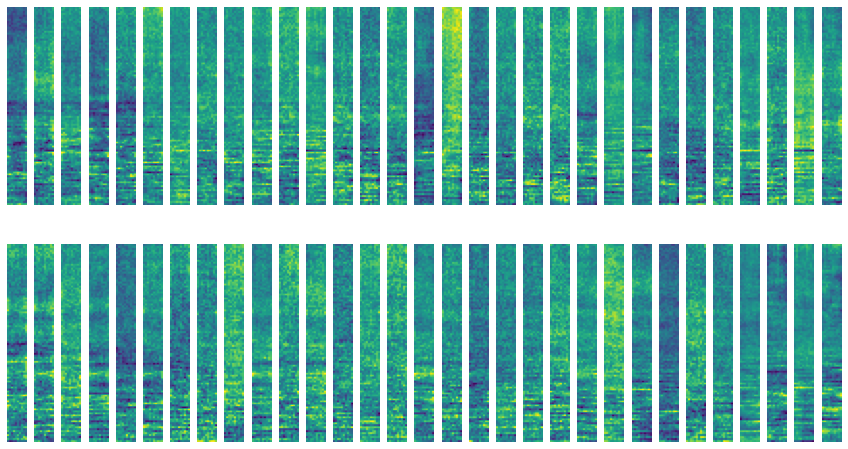

In [12]:
model = LogReg().to(device)
path = '/mnt/pesaranlab/People/Capstone_students/Yue/model_v5'
model.load_state_dict(torch.load('{}/lr_CH{}_reg{}_alpha{}_epoch2.pt'.format(path, CH, l2, alpha)))
weights = model.linear.weight.view(62, 100, 10)
plt.figure(figsize=(15,8))
for i in range(62):
    weights_sub = weights[i].detach().cpu()
    plt.subplot(2,31,i+1)
    plt.axis('off')
    plt.imshow(weights_sub)
    # plt.clim(-0.03, 0.03)
plt.show()

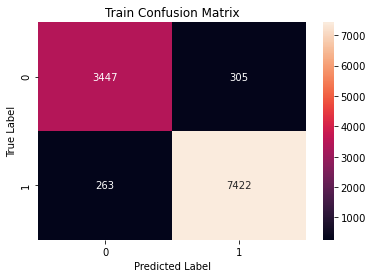

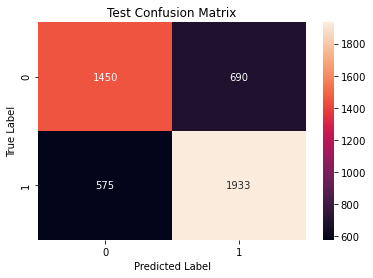

In [39]:
predictions_train = np.stack(train_predictions[-1:][0][:-1]).flatten()
labels_train = np.stack(train_labels[-1:][0][:-1]).flatten()
predictions_val = np.stack(validation_predictions[-1:][0][:-1]).flatten()
labels_val = np.stack(validation_labels[-1:][0][:-1]).flatten()

predictions_train = np.concatenate((predictions_train, train_predictions[-1:][0][-1:][0]))
labels_train = np.concatenate((labels_train, train_labels[-1:][0][-1:][0]))
predictions_val = np.concatenate((predictions_val, validation_predictions[-1:][0][-1:][0]))
labels_val = np.concatenate((labels_val, validation_labels[-1:][0][-1:][0]))

df_train = pd.DataFrame({'predictions': predictions_train, 'labels': labels_train})
df_val = pd.DataFrame({'predictions': predictions_val, 'labels': labels_val})

cm_train = confusion_matrix(labels_train, predictions_train)
cm_test = confusion_matrix(labels_val, predictions_val)
ax = plt.axes()
sn.heatmap(cm_train, annot = True, fmt = "d", ax = ax)
ax.set_title('Train Confusion Matrix')
ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label')
plt.show()
ax = plt.axes()
sn.heatmap(cm_test, annot = True, fmt = "d", ax = ax)
ax.set_title('Test Confusion Matrix')
ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label')
plt.show()